<h1> SAw on Face Dataset </h1>

Loading packages

In [7]:
import numpy as np 
from functions import *
import structures as st
from sklearn.datasets import make_spd_matrix
from noise_functions import add_spnoise, add_noise

import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle

from sklearn.datasets import fetch_olivetti_faces
import logging 
from numpy.random import RandomState
rng = RandomState(0)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

faces, _ = fetch_olivetti_faces(return_X_y=True, shuffle=True, random_state=rng)
n_samples, n_features = faces.shape

faces_centered = faces# - faces.mean(axis=0)

def f(v, xi, gamma, ui, L):
    return 0.5 * np.linalg.norm(div(v) + xi) ** 2 + np.trace(L.T @ gamma.reshape(64,64)) * TV(ui) 
    
def g(v, gamma, L, verbose):
    mx = 0 
    for i in range(64):
        for j in range(64):
            vec = np.array([v[0,i,j],v[1,i,j]])
            norm = np.linalg.norm(vec)
            scale = np.trace(L.T @ gamma.reshape(64,64))
            if vec.any() > scale:
                mx += 1 
    if mx == 0:
        return 0 
    else:
        return 10000000

In [8]:
noise_level = np.sqrt(0.01)
prob = 0.3

dataset = []
for img in faces_centered[0:370]:
    noisy = add_spnoise(img.reshape(64,64).copy(), noise_level, prob).reshape(64,64)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.reshape(64,64)
    im = (im - im.min())/(im.max() - im.min())
    dataset.append([img.reshape(64,64), noisy])

dataset_test = []
for img in faces_centered[370:400]:
    noisy = add_spnoise(img.reshape(64,64).copy(), noise_level, prob).reshape(64,64)
    noisy = (noisy - noisy.min())/(noisy.max() - noisy.min())
    im = img.reshape(64,64)
    im = (im - im.min())/(im.max() - im.min())
    dataset_test.append([img.reshape(64,64), noisy])

In [9]:
L = make_spd_matrix(64)
for s in range(64):
    for t in range(64):
        L[s,t] = max(L[s,t], 1)
L_tilde = L
k = 0
max_iterations = 5
V = [im_dual(_[1]) for _ in dataset]

N = len(dataset)
kappa = 50
l = 10

errors = []
rec_error = []
Ls = [L]
digs = []
bottom = 1
theta = 1

Gammas = []
for d in dataset:
    noisy = d[1]
    ID = im_dual(noisy)
    gamma = 0 * noisy
    for i in range(64):
        for j in range(64):
            gamma[i,j] = np.linalg.norm(np.array([ID[0, i, j], ID[1,i,j]]), 2)
    gamma = np.array(gamma).reshape(64*64)
    Gammas.append(gamma)

while k < max_iterations and abs(theta) > 1e-9:
    Xi = 0*L
    for i, x in enumerate(dataset):
        true_image = x[0]
        noisy = x[1]
        tv = TV(true_image)
        gamma = Gammas[i]
        v = V[i]
        Xi += (1/kappa) * (tv - TV(div(v) + noisy)) * gamma.reshape(64, 64)
    L_tilde = L - Xi
    for i in range(64):
        for j in range(64):
            if L_tilde[i,j] <0:
                L_tilde[i,j] = 0
    V_tilde = []           
    for i, v in enumerate(V):
        noisy = dataset[i][1]
        v_tilde = 0 * v
        gamma = Gammas[i]
        v_div = div(v)
        z = im_dual(v_div + noisy)
        scale = np.trace(L.T @ gamma.reshape(64,64))
        for i in range(64):
            for j in range(64):
                vec = np.array([z[0,i,j], z[1,i,j]])
                norm = np.linalg.norm(vec, 2)
                if norm > 0:
                    for p in range(2):
                        if v_tilde[p, i, j] !=0:
                            v_tilde[p, i, j] = (z[p, i, j]/norm) * scale
        V_tilde.append(v_tilde)
    v_component = 0
    L_component = 0
    for i, v in enumerate(V): 
        noisy = dataset[i][1]
        v_tilde = V_tilde[i]
        gamma = Gammas[i]
        true_image = dataset[i][0]
        nabla_v = im_dual(div(v) + noisy)
        v_component += -np.trace(nabla_v[0].T @ (v - v_tilde)[0]) - np.trace(nabla_v[1].T @ (v - v_tilde)[1])
        L_component += TV(true_image) * np.trace((L - L_tilde).T @ gamma.reshape(64,64))
    
    top = (v_component + L_component)/N
    bottom = l * np.linalg.norm(L - L_tilde, 'fro') ** 2 
    if bottom < 1e-6:
        break
    theta = min(1, top/bottom)

    L = L + theta * (L_tilde - L)
    for i, v in enumerate(V):
        V[i] = v + theta * (V_tilde[i] - v)
    
    Ls.append(L)

    if (k + 1) % 1 == 0:
        print(f'{k + 1} iterations complete')
    k += 1

1 iterations complete
2 iterations complete
3 iterations complete
4 iterations complete
5 iterations complete


In [10]:
s = 20
R = np.sqrt(np.linalg.eig(L.T @ L)[0].max().real)

noisy = dataset_test[s][1]
noisy2 = dataset_test[11][1]
noisy3 = dataset_test[15][1]
ID = im_dual(noisy)
ID2 = im_dual(noisy2)
ID3 = im_dual(noisy3)
gamma = 0 * noisy
gamma2 = 0 * noisy2
gamma3 = 0 * noisy3
for i in range(64):
    for j in range(64):
        gamma[i,j] = np.linalg.norm(np.array([ID[0, i, j], ID[1,i,j]]), 2)
        gamma2[i,j] = np.linalg.norm(np.array([ID2[0, i, j], ID2[1,i,j]]), 2)
        gamma3[i,j] = np.linalg.norm(np.array([ID3[0, i, j], ID3[1,i,j]]), 2)
gamma = np.array(gamma).reshape(64*64)
gamma2 = np.array(gamma2).reshape(64*64)
gamma3 = np.array(gamma3).reshape(64*64)
w = np.trace(L.T @ gamma.reshape(64, 64))/R
w2 = np.trace(L.T @ gamma2.reshape(64, 64))/R
w3 = np.trace(L.T @ gamma3.reshape(64, 64))/R

In [11]:
denoised = []
denoised2 = []
denoised3 = []

for _ in Ls:
    w = np.trace(_ @ gamma.reshape(64, 64))/R
    w2 = np.trace(_ @ gamma2.reshape(64, 64))/R
    w3 = np.trace(_ @ gamma3.reshape(64, 64))/R
    denoised.append(denoise_tv_chambolle(noisy, abs(1/w)))
    denoised2.append(denoise_tv_chambolle(noisy2, abs(1/w2)))
    denoised3.append(denoise_tv_chambolle(noisy3, abs(1/w2)))

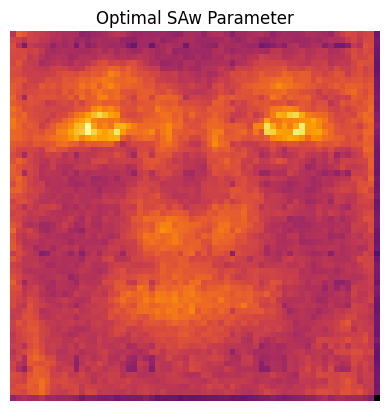

In [12]:
plt.imshow(-L, cmap = 'inferno')
plt.title('Optimal SAw Parameter')
plt.axis('off')
plt.show()

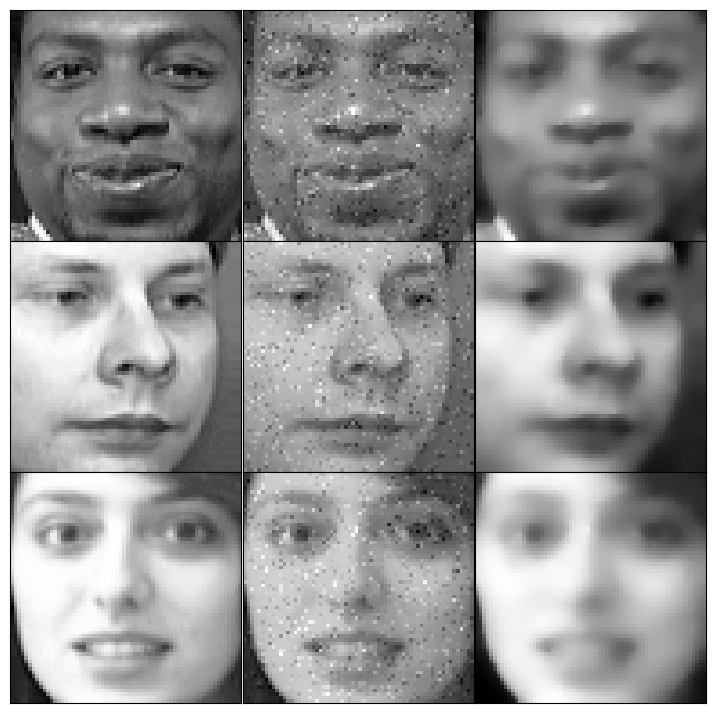

In [13]:
fig, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(9,9), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0, wspace=0.0))
axes[0,0].imshow(dataset_test[s][0], cmap = 'grey')
axes[0,1].imshow(noisy, cmap = 'grey')
axes[0,2].imshow(denoised[-1], cmap = 'grey')

axes[1,0].imshow(dataset_test[11][0], cmap = 'grey')
axes[1,1].imshow(noisy2, cmap = 'grey')
axes[1,2].imshow(denoised2[-1], cmap = 'grey')

axes[2,0].imshow(dataset_test[15][0], cmap = 'grey')
axes[2,1].imshow(noisy3, cmap = 'grey')
axes[2,2].imshow(denoised3[-1], cmap = 'grey')

In [14]:
error = 0 
for k, d in enumerate(dataset_test):
    noisy = d[1]
    true_image = d[0]
    ID = im_dual(noisy)
    gamma = 0 * noisy
    for i in range(64):
        for j in range(64):
            gamma[i,j] = np.linalg.norm(np.array([ID[0, i, j], ID[1,i,j]]), 2)
    gamma = np.array(gamma).reshape(64*64)
    w = np.trace(L.T @ gamma.reshape(64, 64))
    denoised = denoise_tv_chambolle(noisy, abs(1/w))
    error += 0.5 * np.linalg.norm(denoised - true_image) ** 2
print(error/30)

10.879841584198465
